# 講談社「Pythonではじめるベイズ機械学習入門」第3章 回帰モデル

## 3.1 線形単回帰モデル

In [10]:
using Distributions
using Plots

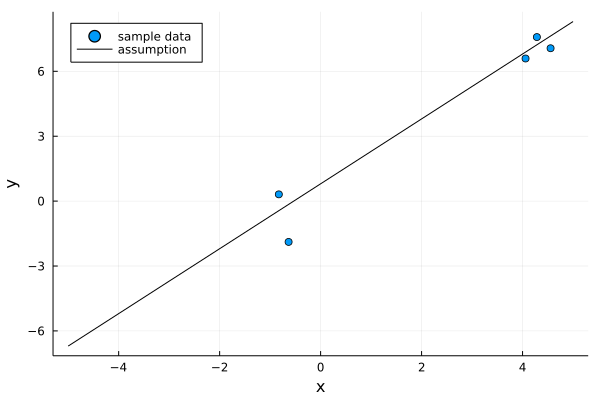

In [2]:
N = 5
true_w1 = 1.5
true_w2 = 0.8
x_data = rand(Uniform(-5, 5), N)
y_data = true_w1 .* x_data .+ true_w2 .+ rand(Normal(0, 1), N)

xs = -5:5
ys = true_w1 .* xs .+ true_w2
scatter(x_data, y_data, xlabel="x", ylabel="y", label="sample data", legend=:topleft)
plot!(xs, ys, color="black", label="assumption")

## Turing.ji

In [11]:
using Turing
using StatsPlots

In [4]:
@model function linear_regression(x, y)
    w1 ~ Normal(0.0, 10.0)
    w2 ~ Normal(0.0, 10.0)
    y ~ MvNormal(w1 * x .+ w2, 1.0)
    return y
end

DynamicPPL.ModelGen{var"###generator#307", (:x, :y), (), Tuple{}}(var"##generator#307", NamedTuple())

In [5]:
model = linear_regression(x_data, y_data)
chain = sample(model, NUTS(), 3000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/akifumiabe/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [6]:
display(chain)

Object of type Chains, with data of type 2000×14×1 Array{Float64, 3}

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = w1, w2

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
          w1  1.5434  0.1803    0.0040  0.0066  823.6917  1.0027
          w2  0.4213  0.6149    0.0137  0.0242  810.0006  1.0029

Quantiles
  parameters     2.5%    25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ───────  ──────  ──────  ──────
          w1   1.1861   1.4232  1.5428  1.6646  1.9071
          w2  -0.7950  -0.0088  0.4221  0.8323  1.6397


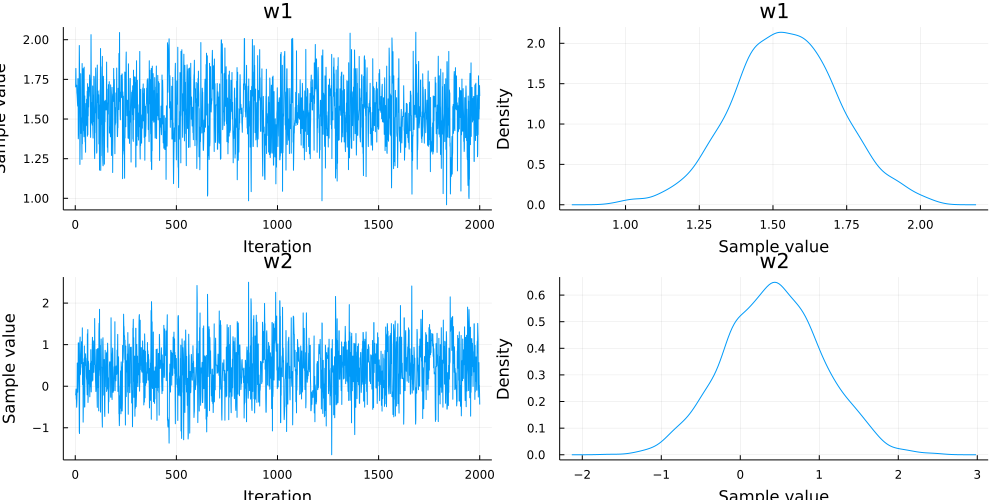

In [7]:
plot(chain)

In [8]:
describe(chain)

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
          w1  1.5434  0.1803    0.0040  0.0066  823.6917  1.0027
          w2  0.4213  0.6149    0.0137  0.0242  810.0006  1.0029

Quantiles
  parameters     2.5%    25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ───────  ──────  ──────  ──────
          w1   1.1861   1.4232  1.5428  1.6646  1.9071
          w2  -0.7950  -0.0088  0.4221  0.8323  1.6397


In [9]:
params = get_params(chain)
@show keys(params)

@show _, i = findmax(params[:lp])
@show params[:w1][i]
@show params[:w2][i];

keys(params) = (:hamiltonian_energy, :n_steps, :numerical_error, :max_hamiltonian_energy_error, :hamiltonian_energy_error, :is_accept, :w1, :tree_depth, :log_density, :step_size, :acceptance_rate, :w2, :lp, :nom_step_size)
(_, i) = findmax(params[:lp]) = (-12.844446763027353, CartesianIndex(604, 1))
(params[:w1])[i] = 1.5509668445326772
(params[:w2])[i] = 0.3825568362101348


In [10]:
function prediction(x, y;
        w1 = params[:w1],
        w2 = params[:w2],
        N = length(w1)
    )
    mean(pdf(Normal(w1[n] * x .+ w2[n], 1.0), y) for n in 1:N)
end

prediction(1.0, 1.0)

0.2458039989572114

  0.193214 seconds (689.63 k allocations: 38.236 MiB, 92.95% compilation time)


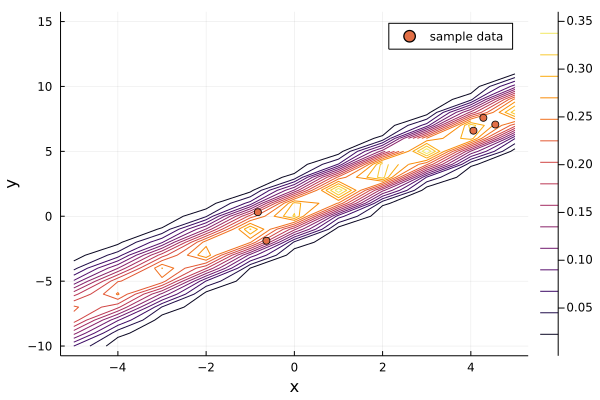

In [11]:
x_new = -5:5
y_new = -10:15
@time prob = prediction.(x_new', y_new)
contour(x_new, y_new, prob)
scatter!(x_data, y_data, xlabel="x", ylabel="y", label="sample data")

## 3.2 線形重回帰モデル

In [12]:
dim = 2
N = 4
true_w = [-1.5; 0.8; 1.2]
x_data = rand(Uniform(-5, 5), (N, dim))
bias = ones(N, 1)
x_data_add_bias = hcat(x_data, bias)
y_data = x_data_add_bias * true_w + rand(Normal(0.0, 1.0), (N, 1))
@show true_w
@show bias
@show x_data_add_bias
@show y_data
;

true_w = [-1.5, 0.8, 1.2]
bias = [1.0; 1.0; 1.0; 1.0;;]
x_data_add_bias = [0.32828172257218036 -1.4985375986090932 1.0; 4.233190167849992 1.8969904540420721 1.0; -4.083731871871368 2.0981619064075137 1.0; -4.087649620108724 3.36056016659003 1.0]
y_data = [-1.2545533880202424; -4.072857914299749; 10.970282727985454; 9.818329874641524;;]


In [13]:
@model function multi_linear_regression(x, y)
    N = size(x, 1)
    w1 ~ Normal(0, 10.0)
    w2 ~ Normal(0, 10.0)
    w3 ~ Normal(0, 10.0)
    for n in 1:N
        y[n] ~ Normal(w1 * x[n, 1] + w2 * x[n, 2] + w3 * x[n, 3], 1.0)
    end
    return y
end

DynamicPPL.ModelGen{var"###generator#336", (:x, :y), (), Tuple{}}(var"##generator#336", NamedTuple())

In [14]:
model = multi_linear_regression(x_data_add_bias, y_data)
chain = sample(model, NUTS(), 3000);

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/akifumiabe/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [15]:
display(chain)

Object of type Chains, with data of type 2000×15×1 Array{Float64, 3}

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = w1, w2, w3

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters     mean     std  naive_se    mcse        ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ─────────  ──────
          w1  -1.6639  0.1604    0.0036  0.0046  1312.6817  0.9996
          w2   0.9074  0.3185    0.0071  0.0095  1201.2204  1.0004
          w3   1.0436  0.6761    0.0151  0.0279  1067.6146  1.0015

Quantiles
  parameters     2.5%    25.0%    50.0%    75.0%    97.5%
  ──────────  ───────  ───────  ───────  ───────  ───────
          w1  -1.9714  -1.7736  -1.6664  -1.5522  -1.3469
          w2   0.2912   0

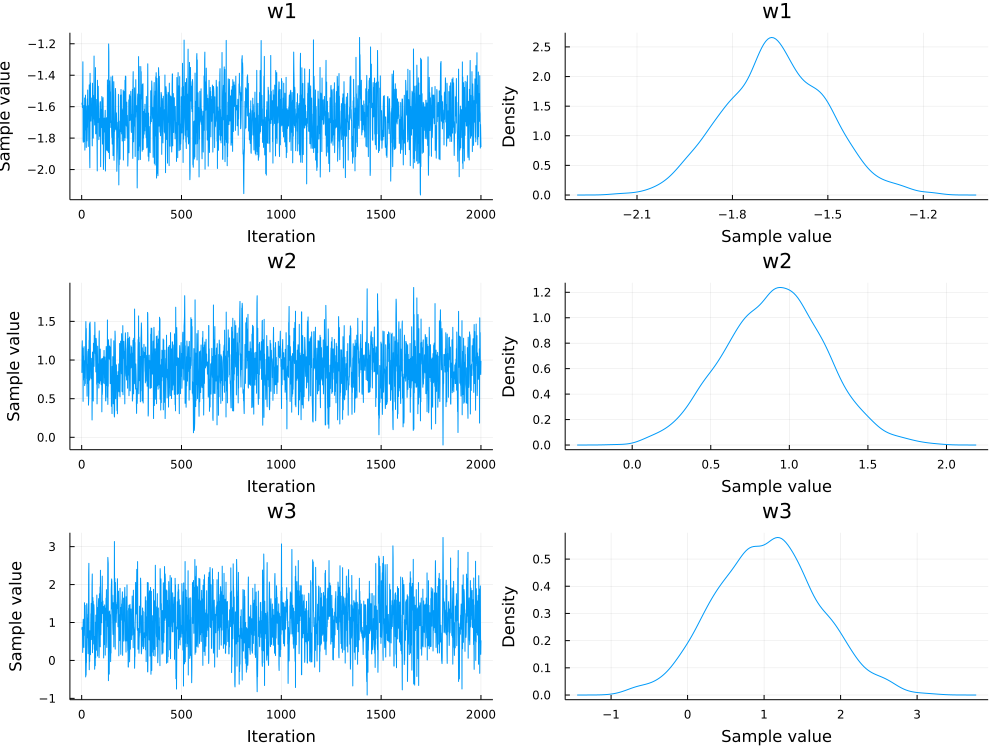

In [16]:
plot(chain)

In [17]:
describe(chain)

2-element Vector{ChainDataFrame}

Summary Statistics
  parameters     mean     std  naive_se    mcse        ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ─────────  ──────
          w1  -1.6639  0.1604    0.0036  0.0046  1312.6817  0.9996
          w2   0.9074  0.3185    0.0071  0.0095  1201.2204  1.0004
          w3   1.0436  0.6761    0.0151  0.0279  1067.6146  1.0015

Quantiles
  parameters     2.5%    25.0%    50.0%    75.0%    97.5%
  ──────────  ───────  ───────  ───────  ───────  ───────
          w1  -1.9714  -1.7736  -1.6664  -1.5522  -1.3469
          w2   0.2912   0.6895   0.9117   1.1206   1.5261
          w3  -0.2455   0.5729   1.0503   1.4859   2.4175


In [59]:
params = get_params(chain)
@show keys(params)

@show _, i = findmax(params[:lp])
@show params[:w1][i]
@show params[:w2][i]
@show params[:w3][i];

keys(params) = (:w3, :hamiltonian_energy, :n_steps, :numerical_error, :max_hamiltonian_energy_error, :hamiltonian_energy_error, :is_accept, :w1, :tree_depth, :log_density, :step_size, :acceptance_rate, :w2, :lp, :nom_step_size)
(_, i) = findmax(params[:lp]) = (-14.796751483276902, CartesianIndex(593, 1))
(params[:w1])[i] = -1.6600973306961049
(params[:w2])[i] = 0.8905600922280748
(params[:w3])[i] = 1.0554504977735257


In [60]:
mean(pdf(Normal(w1[n] * x .+ w2[n], 1.0), y) for i in 1:N for j in 1:L)

2000

In [57]:
function prediction(x;
        w1 = params[:w1],
        w2 = params[:w2],
        w3 = params[:w3],
        N = size(x, 1),
        L = length(w1)
    )
    pdf(Normal(), y) for n in 1:N
    
end

prediction (generic function with 1 method)

In [ ]:
function prediction(x, y;
        w1 = params[:w1],
        w2 = params[:w2],
        N = length(w1)
    )
    mean(pdf(Normal(w1[n] * x .+ w2[n], 1.0), y) for i in 1:N for j in 1:L)
end

In [61]:
xs = range(-5, 5, length=10)
x1 = repeat(xs, inner=(length(xs))) # xsの個々の要素を、xsの要素数の回数分、繰り返す
x2 = repeat(xs, outer=(length(xs))) # xs全体を、xsの要素数の回数分、繰り返す
x_new = hcat(x1, x2)
bias = ones(size(x_new, 1))
x_new_add_bias = hcat(x_new, bias)
size(x_new_add_bias)

(100, 3)